In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as stats
import seaborn as sns

concepts:
* empirical distribution
* deterministic sample
* random sample

# Load weather data and visualize

In [2]:
# get latitude and longitude of zip code 94305
# https://www.latlong.net/place/palo-alto-ca-usa-4187.html
# 37.4683° N, 122.1439° W
lat = 37.4683
lon = -122.1439

In [3]:
from meteostat import Point, Daily

# Set time period
start = datetime(2022, 1, 1)
end = datetime(2022, 12, 31)

# Create Point for Palo Alto, CA
paloalto = Point(lat, lon, 70)

# Get daily data
data = Daily(paloalto, start, end)
data = data.fetch()
data.head()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
2022-01-01,6.7,0.6,10.6,0.0,NaN,3.0,6.9,NaN,1022.3,NaN
2022-01-02,6.3,-2.4,11.2,0.0,NaN,111.0,6.9,NaN,1024.5,NaN
2022-01-03,9.9,5.6,12.6,0.9,NaN,162.0,14.4,NaN,1023.3,NaN
2022-01-04,11.3,9.2,14.6,2.1,NaN,176.0,7.9,NaN,1026.3,NaN
2022-01-05,11.0,8.6,13.6,0.1,NaN,204.0,8.0,NaN,1025.2,NaN


Poll: how should we plot temperature?
* A) line plot
* B) scatter plot
* C) bar chart
* D) pie chart
* E) box-and-whiskers plot

Poll: how should we plot precipitation?
* A) line plot
* B) scatter plot
* C) bar chart
* D) pie chart
* E) box-and-whiskers plot


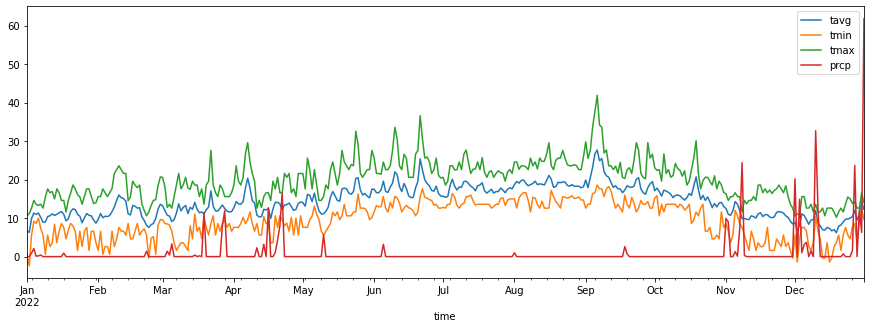

In [6]:
# Plot line chart including average, minimum and maximum temperature
data.plot(y=['tavg', 'tmin', 'tmax', 'prcp'], figsize=(15, 5))
plt.show()

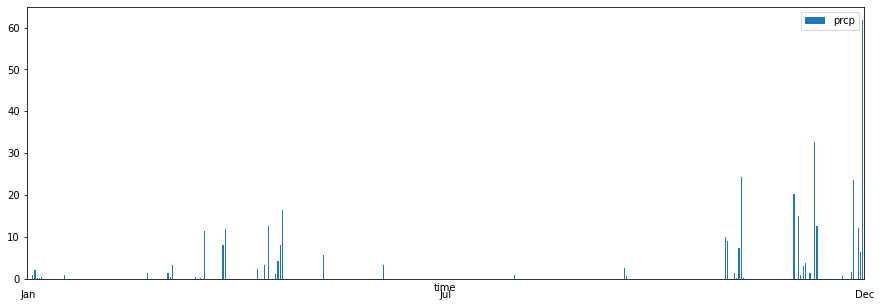

In [13]:
# Plot bar chart of precipitation
data.plot(y='prcp', kind='bar', figsize=(15, 5))
# sns.histplot(data=data, x='prcp', bins=12)
# suppress x axis labels
plt.xticks([])
# add x axis label for January, July, and December
plt.text(0, -5, 'Jan', ha='center', va='bottom')
plt.text(182, -5, 'Jul', ha='center', va='bottom')
plt.text(365, -5, 'Dec', ha='center', va='bottom')
plt.show()

([<matplotlib.axis.XTick at 0x7fbd8b35f6d0>,
 [Text(0, 0, 'Jan'),
  Text(1, 0, 'Feb'),
  Text(2, 0, 'Mar'),
  Text(3, 0, 'Apr'),
  Text(4, 0, 'May'),
  Text(5, 0, 'Jun'),
  Text(6, 0, 'Jul'),
  Text(7, 0, 'Aug'),
  Text(8, 0, 'Sep'),
  Text(9, 0, 'Oct'),
  Text(10, 0, 'Nov'),
  Text(11, 0, 'Dec')])

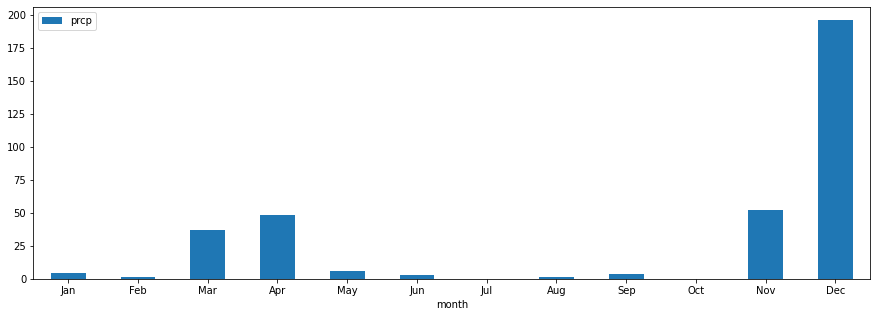

In [18]:
# add column for month
data['month'] = data.index.month
# group by month and calculate total precipitation
rain_bymonth = data.groupby('month').sum()
# plot bar chart of total precipitation by month
rain_bymonth.plot(y='prcp', kind='bar', figsize=(15, 5))
# rotate x axis labels
plt.xticks(rotation=0)
# correct x ticks to list month names
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

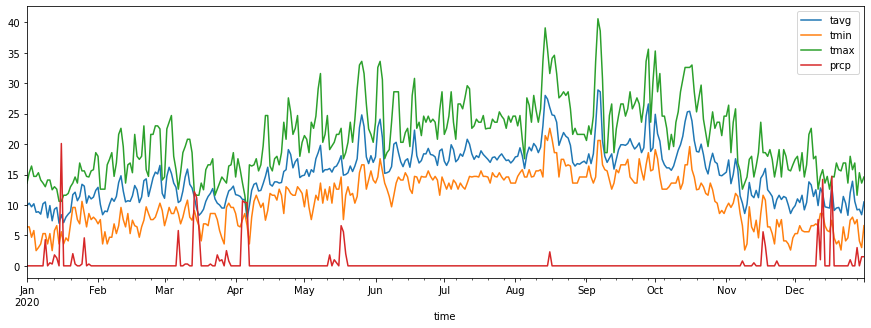

In [15]:
# write a function to plot the data for each year
def plot_year(year, location=paloalto):
    start = datetime(year, 1, 1)
    end = datetime(year, 12, 31)
    data = Daily(location, start, end)
    data = data.fetch()
    data.plot(y=['tavg', 'tmin', 'tmax', 'prcp'], figsize=(15, 5))
    plt.show()
    return data

rain2020 = plot_year(2020)

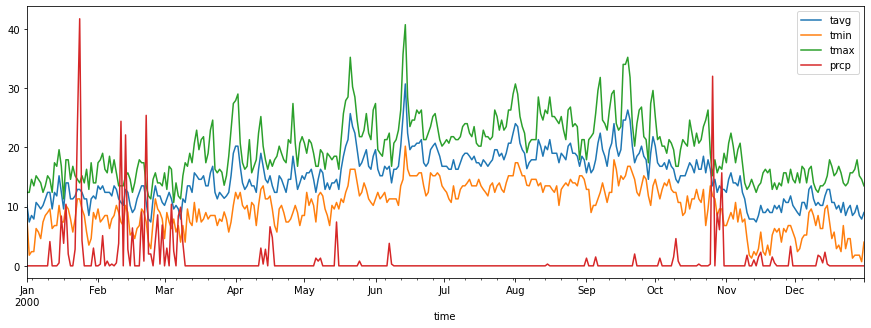

In [16]:
rain2000 = plot_year(2000)

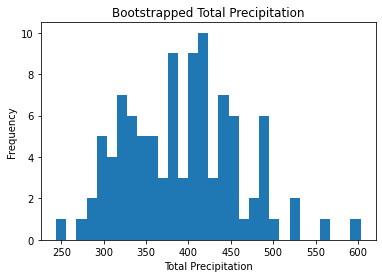

In [21]:
# pick a year to analyze 
rain = rain2000

# Bootstrap sample size
sample_size = 100

# Initialize arrays to store bootstrapped totals
totals = np.zeros(sample_size)

# Bootstrap process
for i in range(sample_size):
    sample = rain['prcp'].sample(n=365, replace=True)
    totals[i] = sample.sum()
    
# Plot the bootstrapped means
plt.hist(totals, bins=30)
plt.xlabel("Total Precipitation")
plt.ylabel("Frequency")
plt.title("Bootstrapped Total Precipitation")
plt.show()

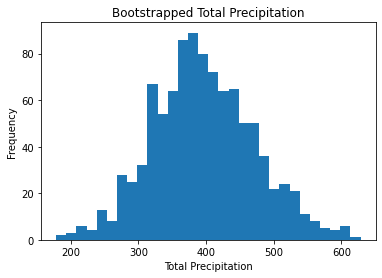

In [24]:
# Hmm, we're still getting a very different distribution each time we run the code.
# Let's increase the number of bootstrap samples to 1000
sample_size = 1000

# Initialize arrays to store bootstrapped totals
totals = np.zeros(sample_size)

# Bootstrap process
for i in range(sample_size):
    sample = rain['prcp'].sample(n=365, replace=True)
    totals[i] = sample.sum()

# Plot the bootstrapped means
plt.hist(totals, bins=30)
plt.xlabel("Total Precipitation")
plt.ylabel("Frequency")
plt.title("Bootstrapped Total Precipitation")
plt.show()

Interesting, the distribution looks more normal...! Why?

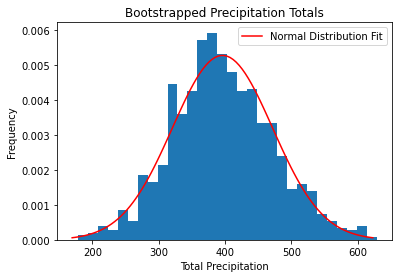

In [25]:
# Fit a normal distribution to the bootstrapped totals
mu = totals.mean()
sigma = totals.std()
# plot the normal approximation
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
y = stats.norm.pdf(x, mu, sigma)
plt.plot(x, y, 'r', label='Normal Distribution Fit')
# compare to empirical bootstrap distribution (plot as a density!)
plt.hist(totals, bins=30, density=True)

plt.xlabel("Total Precipitation")
plt.ylabel("Frequency")
plt.title("Bootstrapped Precipitation Totals")
plt.legend()
plt.show()

# Bootstrap confidence intervals

two ways to compute bootstrap confidence intervals:
1. percentiles of bootstrapped distribution
2. normal approximation

motivating question:
a *100 year flood* is a flood that has a 1% chance of occurring each year. 
how can we estimate a "100 year flood" level using only data from one year?

## poll: 
looking at figure above, how much rainfall (in inches) do you think constitutes a 100 year flood at Stanford?

In [28]:
# normal approximation
mu = totals.mean()
sigma = totals.std()

# a 100 year flood is given by the 99th percentile of the normal distribution with mean mu and standard deviation sigma
stats.norm.ppf(0.99, mu, sigma)

571.7118023723605

In [27]:
# percentile method
# a 100 year flood is given by the 99th percentile of the bootstrapped totals
np.percentile(totals, 99)

586.021

Percentile method
* pro: doesn't use normal approximation
* con: less stable -> requires more bootstrap samples

recommendation: 
1. use percentiles when n is small (make sure number of resamples B is big!)
2. use the normal approximation when n is large and the distribution of your statistic looks normal-ish

If the year 2000 was normal, how surprised should we be to observe a mean like that of 2020?
Answer:
* Form a 95% confidence interval using the bootstrapped means
* The chance that a draw of rainfall from the same distribution as in the year 2000 would produce rainfall outside the 95% confidence intervals is <5%
* Compare mean rainfall in other years to that confidence interval

In [13]:
# Calculate quantiles of bootstrapped totals
quantiles = np.percentile(totals, [2.5, 25, 50, 75, 97.5])
print("Quantiles of Bootstrapped Totals:")
print(quantiles)

# Calculate the 95% confidence interval
ci = np.percentile(totals, [2.5, 97.5])
print("95% Confidence Interval:")
print(ci)

Quantiles of Bootstrapped Totals:
[0. 0. 0. 0. 0.]
95% Confidence Interval:
[0. 0.]


In [55]:
# compare mean rainfall in the past 20 years to the 95% confidence interval
def grab_year(year):
    start = datetime(year, 1, 1)
    end = datetime(year, 12, 31)
    data = Daily(location, start, end)
    data = data.fetch()
    return data

in_ci = 0
for year in range(2001, 2023):
    rain = grab_year(year)
    total = rain['prcp'].sum()
    print(f"{year} total rainfall: {total}")
    print(f"{year} in 95% confidence interval? {ci[0] < total < ci[1]}")
    if ci[0] < total < ci[1]:
        in_ci += 1

print(f"{in_ci} years in 95% confidence interval")

2001 total rainfall: 406.1
2001 in 95% confidence interval? True
2002 total rainfall: 318.1
2002 in 95% confidence interval? True
2003 total rainfall: 262.3
2003 in 95% confidence interval? False
2004 total rainfall: 301.4
2004 in 95% confidence interval? True
2005 total rainfall: 430.5
2005 in 95% confidence interval? True
2006 total rainfall: 366.09999999999997
2006 in 95% confidence interval? True
2007 total rainfall: 198.1
2007 in 95% confidence interval? False
2008 total rainfall: 297.30000000000007
2008 in 95% confidence interval? True
2009 total rainfall: 319.8
2009 in 95% confidence interval? True
2010 total rainfall: 461.79999999999995
2010 in 95% confidence interval? True
2011 total rainfall: 288.6
2011 in 95% confidence interval? True
2012 total rainfall: 333.0
2012 in 95% confidence interval? True
2013 total rainfall: 78.6
2013 in 95% confidence interval? False
2014 total rainfall: 396.90000000000003
2014 in 95% confidence interval? True
2015 total rainfall: 220.5
2015 in 9

Faster than sampling more: 
* use a normal approximation to the bootstrap distribution
* use the normal quantiles to form a 95% confidence interval

In [50]:
# Compare to quantiles of normal distribution
print("Quantiles of Normal Distribution:")
print(stats.norm.ppf([0.025, 0.25, 0.5, 0.75, 0.975], mu, sigma))

Quantiles of Normal Distribution:
[242.41767067 344.56630091 398.1638     451.76129909 553.90992933]
